# 1. Importing libraries and data

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt


## Install necessary libraries

In [4]:
!pip install wurlitzer --upgrade
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.8 MB/s eta 0:00:0000:010:01


## Import libraries

In [5]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.15.0
KerasNLP version: 0.8.2


## Import data

In [6]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# 2. Data analysis

## Check the data

In [7]:
print(df_train.describe())

                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


In [8]:
print(df_train.head(5))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [9]:
df_test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Let's check the keywords and location

In [10]:
# Count occurrences of each keyword
df_train['keyword_count'] = df_train.groupby('keyword')['keyword'].transform('count')

# Count occurrences of target values (0 and 1) within each keyword group
df_train['target_0_count'] = df_train.groupby(['keyword', 'target'])['target'].transform(lambda x: (x == 0).sum())
df_train['target_1_count'] = df_train.groupby(['keyword', 'target'])['target'].transform(lambda x: (x == 1).sum())

In [ ]:
# Set up the figure and axes
plt.figure(figsize=(8, 72), dpi=100)
sns.set(style="whitegrid")

# Create the plot
sns.countplot(y='keyword', hue='target', data=df_train, palette={0: 'green', 1: 'red'})

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Counts of Keywords and Target Values')

# Add legend
plt.legend(title='Target', loc='upper right')

# Show plot
plt.show()

## Let's check information about tweets length

In [11]:
# Count words in each tweet
df_train['number_of_words'] = df_train['text'].apply(lambda x: len(x.split()))
df_test['number_of_words'] = df_test['text'].apply(lambda x: len(x.split()))

# Count letters in each tweet
df_train['number_of_characters'] = df_train['text'].apply(lambda x: len(x))
df_test['number_of_characters'] = df_test['text'].apply(lambda x: len(x))

# Count unique words in each tweet
df_train['number_of_unique_words'] = df_train['text'].apply(lambda x: len(set(x.split())))
df_test['number_of_unique_words'] = df_test['text'].apply(lambda x: len(set(x.split())))

# Count unique letters in each tweet
df_train['number_of_unique_characters'] = df_train['text'].apply(lambda x: len(set(x)))
df_test['number_of_unique_characters'] = df_test['text'].apply(lambda x: len(set(x)))
                                                              
# Get mean length of word
df_train['word_mean_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['word_mean_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Count number of hashtags
df_train['number_of_hashtags'] = df_train['text'].apply(lambda x: len([c for c in x if c == '#']))
df_test['number_of_hashtags'] = df_test['text'].apply(lambda x: len([c for c in x if c == '#']))

# Count number of mentions
df_train['number_of_mentions'] = df_train['text'].apply(lambda x: len([c for c in x if c == '@']))
df_test['number_of_mentions'] = df_test['text'].apply(lambda x: len([c for c in x if c == '@']))

## Let's plot it

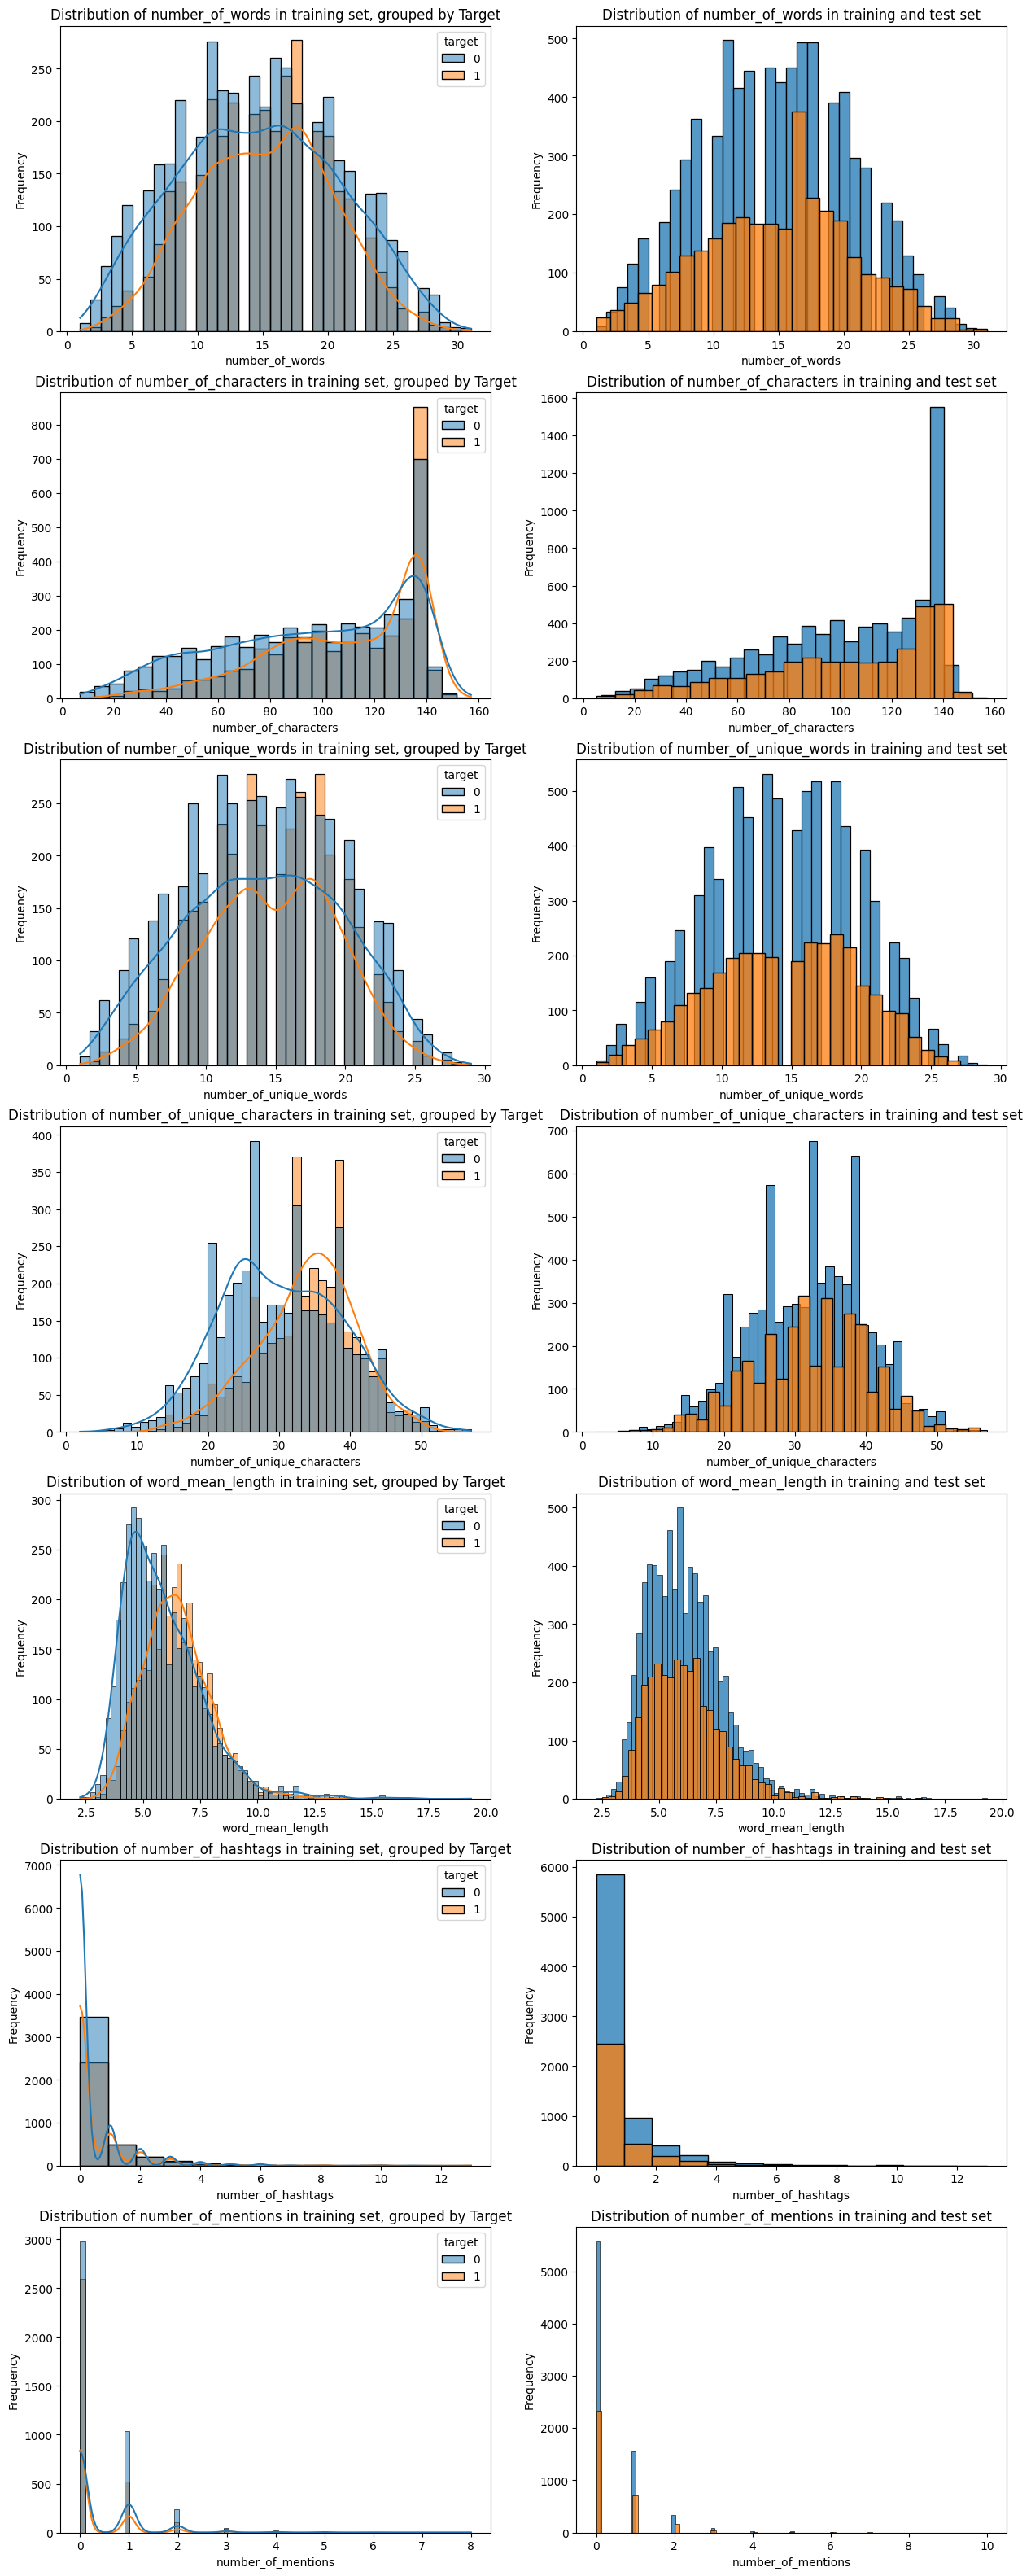

In [12]:
columns = ['number_of_words', 'number_of_characters', 'number_of_unique_words', 'number_of_unique_characters', 'word_mean_length', 'number_of_hashtags', 'number_of_mentions']

# Create subplots with 7 rows and 2 columns
fig, axs = plt.subplots(len(columns), 2, figsize=(15, (len(columns)+1)*5))

for index, column in enumerate(columns):
    sns.histplot(data=df_train, x=column, hue='target', kde=True, ax=axs[index, 0])
    axs[index, 0].set_xlabel(column)
    axs[index, 0].set_ylabel('Frequency')
    axs[index, 0].set_title('Distribution of {} in training set, grouped by Target'.format(column))
    sns.histplot(data=df_train, x=column, label='Training', ax=axs[index][1])
    sns.histplot(data=df_test, x=column, label='Test', ax=axs[index][1])
    axs[index, 1].set_xlabel(column)
    axs[index, 1].set_ylabel('Frequency')
    axs[index, 1].set_title('Distribution of {} in training and test set'.format(column))

# Show plot
plt.show()

## Some tweets are multiple times inside the database and some of them have both targets

In [13]:
df_train['is_unique'] = df_train.groupby('text')['text'].transform('count') == True
non_unique_tweets = df_train[df_train['is_unique'] == False]['text'].unique()

different_target_values = df_train[df_train['text'].isin(non_unique_tweets)].groupby('text')['target'].nunique() > 1
non_unique_texts_different_targets = different_target_values[different_target_values].index.tolist()
print(non_unique_texts_different_targets)

['#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect', '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'Caution: breathing may be hazardous to your health.', 'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam', 'Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you! #Afterlife', 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!', 'I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????', 'In #is

## Let's drop the tweets that has both targets because they can make the model worse

In [14]:
df_train = df_train[~df_train['text'].isin(non_unique_texts_different_targets)]
df_train.reset_index(drop=True, inplace=True)

# 3. Data preprocessing

In [ ]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

# 4. Load a DistilBERT model from Keras NLP

In [ ]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

# 5. Train your own model, fine-tuning BERT

In [ ]:
from keras.optimizers import Adam

print(len(X_train))

# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    #optimizer='adam',
    optimizer = Adam(learning_rate=1e-5),
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

# Save the fitted classifier to file

In [ ]:
import pickle

# Save history to a file
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
# Save classifier to a file
with open('bert_classifier_default.pkl', 'wb') as file:
    pickle.dump(classifier, file)

# 6. Create and display confusion matrix

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

In [ ]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

## Check confusion matrix on validation set

In [ ]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")


# 7. Generate the submission file

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

## Predict values for tweets in the submission dataset

In [ ]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

## Save submission to csv

In [ ]:
sample_submission.to_csv("submission.csv", index=False)

# 8. Make a prediction using word2vec

In [30]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

word2vec_model = Word2Vec(df_train["text"], vector_size=100, window=5, min_count=1, workers=4)

## Function to average word vectors for a sentence

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv.get_vector(word))
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

## Create feature vectors for sentences and split data into train and test sets

In [ ]:
X_w2v = [average_word_vectors(sentence, word2vec_model, word2vec_model.wv.key_to_index, 100) for sentence in df_train["text"]]

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, df_train["target"], test_size=0.2, random_state=42)

## Train logistic regression classifier

In [ ]:
classifier_w2v = LogisticRegression(max_iter=1000)
classifier_w2v.fit(X_train_w2v, y_train_w2v)

## Predict labels for test set

In [ ]:
y_pred_w2v = classifier_w2v.predict_proba(X_test_w2v)

In [ ]:
displayConfusionMatrix(y_test_w2v, y_pred_w2v, "Validation")

# 9. Generate the submission file for word2vec and logistic regression

In [ ]:
X_test_w2v = [average_word_vectors(sentence, word2vec_model, word2vec_model.wv.key_to_index, 100) for sentence in X_test]
sample_submission["target"] = np.argmax(classifier_w2v.predict(X_test_w2v), axis=0)

In [ ]:
sample_submission.to_csv("submission_word2vec.csv", index=False)

# 10. Create and test own transformer

In [88]:
from transformers import BertTokenizer
import tensorflow as tf
import keras_nlp
from sklearn.model_selection import train_test_split
import numpy as np


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Split data into train and test sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df_train['text'], df_train['target'], test_size=0.2, random_state=42)

train_labels = np.array(train_labels).reshape(-1)
val_labels = np.array(val_labels).reshape(-1)

## Remove special signs, URLS, mentions etc

In [82]:
import re

# Define a function to preprocess text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters, URLs, and mentions using regular expressions
    text = re.sub(r'http\S+|www.\S+|@[^\s]+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Apply preprocessing to train, validation, and test texts
train_texts = train_texts.apply(preprocess_text)
val_texts = val_texts.apply(preprocess_text)

In [83]:
train_tokenized_texts = train_texts.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
val_tokenized_texts = val_texts.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [84]:
print(val_tokenized_texts)

3148    [101, 2234, 2408, 2023, 2543, 2678, 2025, 3067...
1662    [101, 2043, 2152, 4827, 1998, 2833, 8902, 2419...
3078    [101, 1045, 2052, 2066, 2000, 16175, 26869, 30...
3012    [101, 2047, 5506, 4098, 12117, 12326, 2015, 22...
3332    [101, 6289, 19848, 2632, 25850, 1999, 2256, 77...
                              ...                        
6612    [101, 6379, 2540, 29525, 4858, 24815, 5081, 20...
5823    [101, 2045, 2024, 1037, 2261, 2111, 8909, 2292...
7080    [101, 2149, 5620, 4311, 1037, 1049, 8372, 2463...
3896    [101, 20772, 3035, 2730, 2006, 2126, 2188, 201...
6955    [101, 2515, 1996, 3098, 3496, 1997, 4302, 1069...
Name: text, Length: 1512, dtype: object


## Preprocess data with a custom tokenizer

In [99]:
from keras.preprocessing.sequence import pad_sequences

packer = keras_nlp.layers.StartEndPacker(
    start_value=tokenizer.convert_tokens_to_ids("[CLS]"),  # [CLS] token for start
    end_value=tokenizer.convert_tokens_to_ids("[SEP]"),    # [SEP] token for end
    pad_value=tokenizer.convert_tokens_to_ids("[PAD]"),    # [PAD] token for padding
    sequence_length=512, 
)

max_sequence_length = max(max(len(seq) for seq in train_tokenized_texts), max(len(seq) for seq in val_tokenized_texts))

# Pad sequences to the maximum length
padded_train_sequences = pad_sequences(train_tokenized_texts, maxlen=max_sequence_length, padding='post', truncating='post', value=tokenizer.pad_token_id)
padded_val_sequences = pad_sequences(val_tokenized_texts, maxlen=max_sequence_length, padding='post', truncating='post', value=tokenizer.pad_token_id)

# Compute the vocabulary size from the tokenized sequences
vocab_size = len(set(token for seq in train_tokenized_texts.tolist() for token in seq))

# Preprocessing function using padded_sequences
def preprocess(x, y):
    x = packer(x)
    x = tf.expand_dims(x, axis=0)  # Add an extra dimension to the features
    y = tf.expand_dims(y, axis=0)  # Add an extra dimension to the labels
    return x, y

# Convert padded_sequences to TensorFlow Dataset
train_ds = tf.data.Dataset.from_tensor_slices((padded_train_sequences, train_labels)).map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((padded_val_sequences, val_labels)).map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

## Create a transformer

In [100]:
class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

class TransformerEncoder(keras.layers.Layer):
    def __init__(self, num_heads, intermediate_dim, dropout):
        super(TransformerEncoder, self).__init__()
        self.num_heads = num_heads
        self.intermediate_dim = intermediate_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.multi_head_attention = keras.layers.MultiHeadAttention(
            num_heads=self.num_heads, key_dim=self.intermediate_dim, dropout=self.dropout
        )
        self.dense_proj = keras.Sequential(
            [keras.layers.Dense(self.intermediate_dim, activation="relu"), keras.layers.Dense(64)]  # Change the output dimension to 64
        )
        self.layernorm_1 = keras.layers.LayerNormalization()
        self.layernorm_2 = keras.layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.multi_head_attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    
    
# Define input layer
token_id_input = keras.Input(
    shape=(None,),
    dtype="int32",
    name="token_ids",
)

# Define the TokenAndPositionEmbedding layer separately
embedding_layer = TokenAndPositionEmbedding(
    vocab_size=vocab_size,
    maxlen=max_sequence_length,  # Use the max sequence length
    embed_dim=64,
)

# Apply the embedding layer to the input
embedded_sequences = embedding_layer(token_id_input)

# Define the TransformerEncoder layer
encoder_layer = TransformerEncoder(
    num_heads=2,
    intermediate_dim=128,
    dropout=0.1,
)

# Apply the TransformerEncoder layer to the embedded sequences
encoded_sequences = encoder_layer(embedded_sequences)

# Extract the representation for classification (using the first token)
representation = encoded_sequences[:, 0, :]

# Add a dense layer for classification
outputs = keras.layers.Dense(2)(representation)

# Define the model with input and output tensors
model = keras.Model(inputs=token_id_input, outputs=outputs)

# Display model summary
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ token_ids (InputLayer)          │ (None, None)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ token_and_position_embedding_8  │ (None, None, 64)          │    683,840 │
│ (TokenAndPositionEmbedding)     │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_7           │ (None, None, 64)          │     83,200 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ get_item_5 (GetItem)            │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_21 (Dense)                │ (None, 2)                 │        130 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 767,170 (2.93 MB)

 Trainable params: 767,170 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

## Train the transformer

In [111]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.AdamW(5e-5),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    jit_compile=True,
)
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
)

Epoch 1/5
6046/6046 ━━━━━━━━━━━━━━━━━━━━ 213s 34ms/step - loss: 0.3662 - sparse_categorical_accuracy: 0.8453 - val_loss: 0.5108 - val_sparse_categorical_accuracy: 0.8009
Epoch 2/5
6046/6046 ━━━━━━━━━━━━━━━━━━━━ 205s 34ms/step - loss: 0.3519 - sparse_categorical_accuracy: 0.8515 - val_loss: 0.5143 - val_sparse_categorical_accuracy: 0.7996
Epoch 3/5
6046/6046 ━━━━━━━━━━━━━━━━━━━━ 207s 34ms/step - loss: 0.3264 - sparse_categorical_accuracy: 0.8639 - val_loss: 0.5369 - val_sparse_categorical_accuracy: 0.7923
Epoch 4/5
6046/6046 ━━━━━━━━━━━━━━━━━━━━ 258s 34ms/step - loss: 0.3105 - sparse_categorical_accuracy: 0.8719 - val_loss: 0.5565 - val_sparse_categorical_accuracy: 0.7930
Epoch 5/5
6046/6046 ━━━━━━━━━━━━━━━━━━━━ 205s 34ms/step - loss: 0.2978 - sparse_categorical_accuracy: 0.8808 - val_loss: 0.5692 - val_sparse_categorical_accuracy: 0.7870


1512/1512 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step


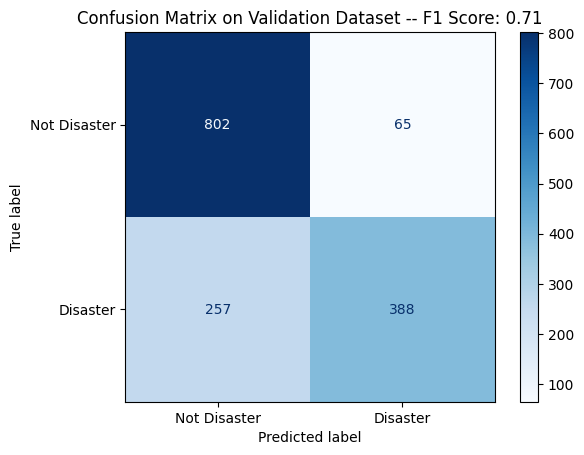

In [112]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

own_bert_val_predictions = model.predict(val_ds)
displayConfusionMatrix(val_labels, own_bert_val_predictions, "Validation")

## Prepare test data

In [108]:
test_texts = df_test['text'].apply(preprocess_text)
test_tokenized_texts = test_texts.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
padded_test_sequences = pad_sequences(test_tokenized_texts, maxlen=max_sequence_length, padding='post', truncating='post', value=tokenizer.pad_token_id)

def preprocess_test(x):
    x = tf.expand_dims(x, axis=0)  # Add an extra dimension
    return packer(x)

# Convert padded_sequences to TensorFlow Dataset
test_ds = tf.data.Dataset.from_tensor_slices(padded_test_sequences).map(
    preprocess_test, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

## Predict labels for test dataset

In [113]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission["target"] = np.argmax(model.predict(test_ds), axis=1)
sample_submission.to_csv("submission_own_BERT.csv", index=False)

3263/3263 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step
